In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

In [2]:
from google.colab import files

uploaded = files.upload()

Saving churn-bigml-20.csv to churn-bigml-20.csv
Saving churn-bigml-80.csv to churn-bigml-80.csv


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train_df = pd.read_csv("churn-bigml-80.csv")
test_df  = pd.read_csv("churn-bigml-20.csv")


In [8]:
print("Training shape:", train_df.shape)
print("Testing shape:", test_df.shape)

Training shape: (2666, 20)
Testing shape: (667, 20)


In [9]:
train_df.head(), test_df.head()

(  State  Account length  Area code International plan Voice mail plan  \
 0    KS             128        415                 No             Yes   
 1    OH             107        415                 No             Yes   
 2    NJ             137        415                 No              No   
 3    OH              84        408                Yes              No   
 4    OK              75        415                Yes              No   
 
    Number vmail messages  Total day minutes  Total day calls  \
 0                     25              265.1              110   
 1                     26              161.6              123   
 2                      0              243.4              114   
 3                      0              299.4               71   
 4                      0              166.7              113   
 
    Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
 0             45.07              197.4               99             16.78   
 1    

In [12]:
print(train_df.columns)

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')


In [13]:
X_train = train_df.drop('Churn', axis=1)
y_train = train_df['Churn']

X_test  = test_df.drop('Churn', axis=1)
y_test  = test_df['Churn']


In [14]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test  = pd.get_dummies(X_test, drop_first=True)

In [15]:
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()


In [18]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [19]:
from sklearn.svm import SVC


In [20]:

svm_linear = SVC(kernel='linear', probability=True, random_state=42)
svm_linear.fit(X_train_scaled, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [21]:
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf.fit(X_train_scaled, y_train)


SVC(probability=True, random_state=42)

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score


In [23]:
def evaluate(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    return {
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "AUC": roc_auc_score(y, y_prob)
    }


In [24]:
print("Linear SVM:", evaluate(svm_linear, X_test_scaled, y_test))
print("RBF SVM:", evaluate(svm_rbf, X_test_scaled, y_test))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Linear SVM: {'Accuracy': 0.8575712143928036, 'Precision': 0.0, 'Recall': 0.0, 'AUC': np.float64(0.7497423629002576)}
RBF SVM: {'Accuracy': 0.8695652173913043, 'Precision': 0.7857142857142857, 'Recall': 0.11578947368421053, 'AUC': np.float64(0.8666635995583363)}


In [25]:
svm_linear = SVC(
    kernel='linear',
    probability=True,
    class_weight='balanced',
    random_state=42
)

svm_rbf = SVC(
    kernel='rbf',
    probability=True,
    class_weight='balanced',
    random_state=42
)

svm_linear.fit(X_train_scaled, y_train)
svm_rbf.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [26]:
print("Linear SVM (Balanced):", evaluate(svm_linear, X_test_scaled, y_test))
print("RBF SVM (Balanced):", evaluate(svm_rbf, X_test_scaled, y_test))

Linear SVM (Balanced): {'Accuracy': 0.7691154422788605, 'Precision': 0.35467980295566504, 'Recall': 0.7578947368421053, 'AUC': np.float64(0.820334928229665)}
RBF SVM (Balanced): {'Accuracy': 0.8440779610194903, 'Precision': 0.47019867549668876, 'Recall': 0.7473684210526316, 'AUC': np.float64(0.8562569009937431)}


In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


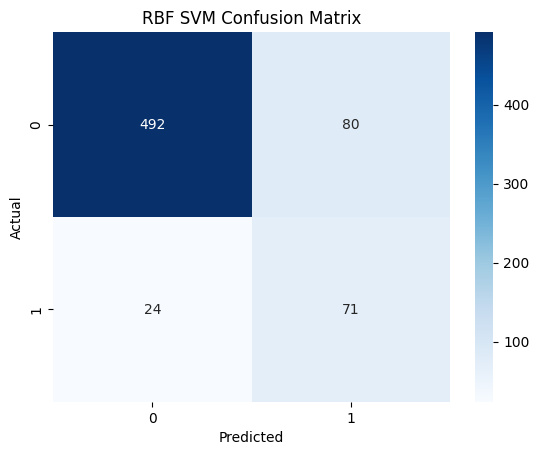

In [28]:
##Confusion Matrix & Heatmap
cm = confusion_matrix(y_test, svm_rbf.predict(X_test_scaled))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('RBF SVM Confusion Matrix')
plt.show()

In [30]:
##ROC Curve Comparison
from sklearn.metrics import roc_curve
y_prob_linear = svm_linear.predict_proba(X_test_scaled)[:,1]
y_prob_rbf = svm_rbf.predict_proba(X_test_scaled)[:,1]

fpr_lin, tpr_lin, _ = roc_curve(y_test, y_prob_linear)
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_prob_rbf)


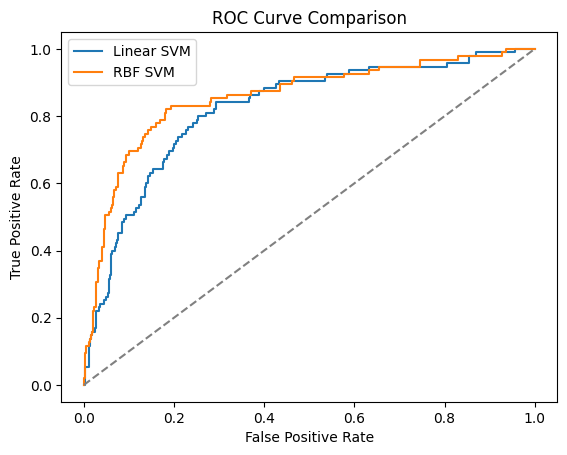

In [31]:
plt.plot(fpr_lin, tpr_lin, label='Linear SVM')
plt.plot(fpr_rbf, tpr_rbf, label='RBF SVM')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()